In [152]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
import numpy as np

In [153]:
X_path = r'D:\NEU Notes\EECE5644 - Intro to ML\Project\X_data.csv'
y_path = r'D:\NEU Notes\EECE5644 - Intro to ML\Project\y_data.csv'
label_path = r'D:\NEU Notes\EECE5644 - Intro to ML\Project\labels.csv'

X = np.loadtxt(X_path, delimiter=',')
y = np.loadtxt(y_path, delimiter=',')
labels = np.loadtxt(label_path, dtype=str, delimiter=',')
X = np.delete(X, 7, axis=1)     # Dropping Packet Delay Budget and Packet Loss Rate columns from the dataset
X = np.delete(X, 6, axis=1)
dataset = np.column_stack((X, y))
subset = dataset[np.random.choice(dataset.shape[0], size=100000, replace=False)]

Xsub = subset[:,:6]
ysub = subset[:,6]

print("Dataset has n=%d samples, each with d=%d features," % X.shape,"as well as %d labels." % y.shape[0])

Dataset has n=466739 samples, each with d=6 features, as well as 466739 labels.


In [154]:
X_train, X_test, y_train, y_test = train_test_split(Xsub, ysub, test_size = 0.3, random_state = 21)

In [155]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(criterion = 'entropy', random_state = 42)

In [156]:
# Performing Grid Search for hyper-parameter tuning
param_grid = {
    'n_estimators': range(1,10),
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1)

In [157]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(1, 10)})

In [158]:
modelPara = grid_search.best_params_
print("Best Parameters:", modelPara)
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}
Accuracy: 0.8249666666666666


In [162]:
# Training with full datasetand best model parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

model = RandomForestClassifier(max_depth=modelPara['max_depth'], min_samples_leaf=modelPara['min_samples_leaf'], min_samples_split=modelPara['min_samples_split'], n_estimators=modelPara['n_estimators'])

model.fit(X_train, y_train)
y_pred =  model.predict(X_test) 

print("Optimal Parameters:",modelPara)

accuracy = acc = accuracy_score(y_test,y_pred)
print("Accuracy:", accuracy)

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (Weighted):", f1_weighted)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print("Confusion matrix:\n",cm)

X shape:  (466739, 6)
y shape:  (466739,)
Optimal Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}
Accuracy: 0.8212638014026368
F1 Score (Weighted): 0.8205338546714426
Confusion matrix:
 [[35061     0  2683]
 [    0 27129 12346]
 [ 9998     0 52805]]


In [160]:
y_test2 = label_binarize(y_test, classes=[0, 1, 2])
y_score = model.predict_proba(X_test)

roc_auc = roc_auc_score(y_test2, y_score, multi_class='ovr', average='weighted')
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9197486422095992


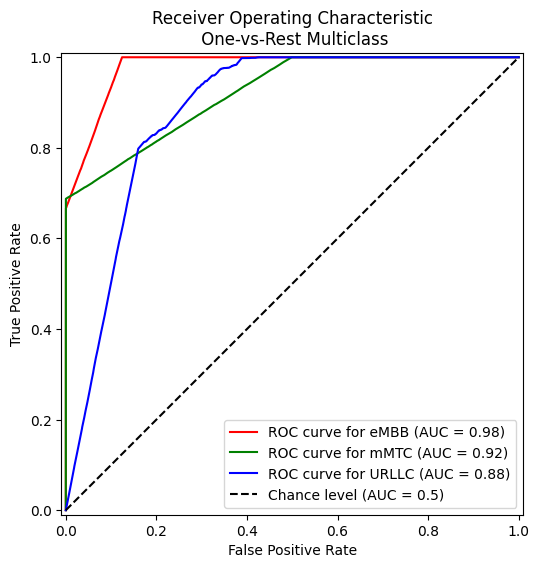

In [163]:
# Plotting ROC Curve (One to Rest)
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

n_classes = 3
fig, ax = plt.subplots(figsize=(6, 6))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

"""
eMBB - 0
mMTC - 1
URLLC - 2
"""
colors = cycle(["red", "green", "blue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Receiver Operating Characteristic\n One-vs-Rest Multiclass",
)